In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import re

import hvplot.pandas
import holoviews as hv

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import RandomOverSampler

In [2]:
# Read the CSV file from the Resources folder into a Pandas DataFrame
df_data = pd.read_csv("output/standings.csv")

# Display the data
df_data.head()

,year,school,conference,wins,losses,winning_pct,conf_wins,conf_losses,conf_winning_pct,ppg_offense,ppg_defense,SRS,SOS
0,2000,Florida State,ACC,11.0,2.0,0.846,8.0,0.0,1.000,39.3,10.5,23.13,5.59
1,2000,Clemson,ACC,9.0,3.0,0.750,6.0,2.0,0.750,34.7,21.1,11.54,2.04
2,2000,Georgia Tech,ACC,9.0,3.0,0.750,6.0,2.0,0.750,32.2,19.8,11.30,1.21
3,2000,Virginia,ACC,6.0,6.0,0.500,5.0,3.0,0.625,20.2,24.3,0.10,3.18
4,2000,North Carolina State,ACC,8.0,4.0,0.667,4.0,4.0,0.500,31.6,28.2,3.92,-0.33


In [3]:
# Check the dataset to determine initial processing steps
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835 entries, 0 to 2834
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              2835 non-null   int64  
 1   school            2835 non-null   object 
 2   conference        2835 non-null   object 
 3   wins              2835 non-null   float64
 4   losses            2835 non-null   float64
 5   winning_pct       2835 non-null   float64
 6   conf_wins         2724 non-null   float64
 7   conf_losses       2724 non-null   float64
 8   conf_winning_pct  2724 non-null   float64
 9   ppg_offense       2835 non-null   float64
 10  ppg_defense       2835 non-null   float64
 11  SRS               2835 non-null   float64
 12  SOS               2835 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 288.1+ KB


In [4]:
# Fill all the non-null values with zero
df_data = df_data.fillna(0)

# Create a UID of year and school
df_data['team'] = '(' + df_data['school'] + ')' + '-' + df_data['year'].astype(str)
df_data['team'] = df_data['team'].str.replace('Louisiana-Monroe', "Louisiana Monroe")
df_data['team'] = df_data['team'].str.replace('Nevada-Las Vegas', "UNLV")

# Set the index to the UID
df_data = df_data.set_index('team')

# Drop the unnecessary columns and set the team column to the index
columns_to_drop = ['year', 'school', 'conference']
df_data = df_data.drop(columns_to_drop, axis=1)

#Preview the dataframe
df_data.head()

,wins,losses,winning_pct,conf_wins,conf_losses,conf_winning_pct,ppg_offense,ppg_defense,SRS,SOS
team,,,,,,,,,,
(Florida State)-2000,11.0,2.0,0.846,8.0,0.0,1.000,39.3,10.5,23.13,5.59
(Clemson)-2000,9.0,3.0,0.750,6.0,2.0,0.750,34.7,21.1,11.54,2.04
(Georgia Tech)-2000,9.0,3.0,0.750,6.0,2.0,0.750,32.2,19.8,11.30,1.21
(Virginia)-2000,6.0,6.0,0.500,5.0,3.0,0.625,20.2,24.3,0.10,3.18
(North Carolina State)-2000,8.0,4.0,0.667,4.0,4.0,0.500,31.6,28.2,3.92,-0.33


In [5]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data
data_scaled = StandardScaler().fit_transform(df_data)

# Creating a DataFrame with with the scaled data
df_scaled = pd.DataFrame(data_scaled, columns=list(df_data.columns))

# Set the index to the team value
df_scaled['team'] = df_data.index
df_scaled = df_scaled.set_index('team')

# Preview the DataFrame
df_scaled.head()

,wins,losses,winning_pct,conf_wins,conf_losses,conf_winning_pct,ppg_offense,ppg_defense,SRS,SOS
team,,,,,,,,,,
(Florida State)-2000,1.475652,-1.523073,1.494088,1.877612,-1.727946,1.894445,1.592163,-2.379177,2.232763,1.238088
(Clemson)-2000,0.824983,-1.129928,1.061912,0.975939,-0.826036,0.982623,0.951487,-0.825182,1.081923,0.455028
(Georgia Tech)-2000,0.824983,-1.129928,1.061912,0.975939,-0.826036,0.982623,0.603294,-1.015767,1.058092,0.271946
(Virginia)-2000,-0.151019,0.049507,-0.063548,0.525102,-0.375080,0.526712,-1.068033,-0.356052,-0.054022,0.706489
(North Carolina State)-2000,0.499649,-0.736783,0.688259,0.074265,0.075875,0.070801,0.519728,0.215701,0.325288,-0.067748


In [6]:
# Create a a list to store inertia values
inertia = []

# Create a a list to store the values of k
k = list(range(1, 11))

# Create a for loop where each value of k is evaluated using the K-means algorithm
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(df_scaled)
    inertia.append(k_model.inertia_)

# Create a dictionary that holds the list values for k and inertia
elbow_data = {"k": k, "inertia": inertia}

# Create a DataFrame using the elbow_data dictionary
df_elbow_data = pd.DataFrame(elbow_data)

# Plot the DataFrame
df_elbow_data.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

C:\Users\grant\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\grant\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\grant\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\grant\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\grant\anaco

:Curve   [k]   (inertia)

In [7]:
# Input value for k from Elbox Curve
k = 3

# Initialize the K-Means model
model = KMeans(n_clusters=int(k), random_state=1)

# Fit the K-Means model using the scaled data
model.fit(df_scaled)

# Predict the clusters to group
groups = model.predict(df_scaled)

# Create a copy of the Dataframe and update with the predicted groups
df_predictions = df_scaled.copy()
df_predictions['group'] = groups

C:\Users\grant\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
# Generate the Variables
x = 'SOS'
y = 'SRS'
team = 'Nebraska'
title = f'Clustering Analysis for {team} comparing {y} vs {x}'

# Generate the main scatter plot
scatter_plot = df_predictions.reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team"
).opts(title=title, yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions.index.str.contains(team)

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions.loc[filter_condition].reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Overlay the two plots to show the original scatter plot and the filtered points with stars
final_plot = scatter_plot * filtered_points

# Render the final plot
final_plot

:Overlay
   .NdOverlay.I  :NdOverlay   [group]
      :Scatter   [SOS]   (SRS,team)
   .NdOverlay.II :NdOverlay   [group]
      :Scatter   [SOS]   (SRS,team)

In [9]:
# Make datatable for Nebraska
df_nebraska = df_predictions.copy()

# Reset the index to turn the 'team' column into a regular column
df_nebraska.reset_index(inplace=True)

# Filter the DataFrame based on the 'team' column containing 'Nebraska'
df_nebraska = df_nebraska[df_nebraska['team'].str.contains('Nebraska')]

# Drop unnecessary columns
df_nebraska = df_nebraska.drop(columns=['wins', 'losses', 'winning_pct', 'conf_wins', 'conf_losses', 'conf_winning_pct', 'ppg_offense', 'ppg_defense', 'SRS', 'SOS'], axis=1)

#Split the year out of the team column
df_nebraska[['team', 'year']] = df_nebraska['team'].str.split('-', expand=True)
df_nebraska = df_nebraska.drop('team', axis=1)

# Add in the Coaches to the dataset
coaches = ['Frank Solich',
           'Frank Solich',
           'Frank Solich',
           'Frank Solich',
           'Bill Callahan',
           'Bill Callahan',
           'Bill Callahan',
           'Bill Callahan',
           'Bo Pelini',
           'Bo Pelini',
           'Bo Pelini',
           'Bo Pelini',
           'Bo Pelini',
           'Bo Pelini',
           'Bo Pelini',
           'Mike Riley',
           'Mike Riley',
           'Mike Riley',
           'Scott Frost',
           'Scott Frost',
           'Scott Frost',
           'Scott Frost',
           'Scott Frost'
          ]

df_nebraska['coach'] = coaches
           
df_nebraska

,group,year,coach
9,0,2000,Frank Solich
126,0,2001,Frank Solich
245,1,2002,Frank Solich
360,0,2003,Frank Solich
481,1,2004,Bill Callahan
600,1,2005,Bill Callahan
718,0,2006,Bill Callahan
841,2,2007,Bill Callahan
957,0,2008,Bo Pelini
1075,0,2009,Bo Pelini


In [10]:
# Determine the frequency of teams in each group
df_team_count = df_predictions.copy()
df_team_count = df_team_count.reset_index()

# Splitting the 'team' column into 'school' and 'season'
df_team_count = df_team_count['team'].str.split('-', expand=True)

# Renaming columns using the rename method
df_team_count = df_team_count.rename(columns={0: 'team', 1: 'year', 2: 'group'})
df_team_count['team'] = df_team_count['team'].str.replace(r"\(", "", regex=True)
df_team_count['team'] = df_team_count['team'].str.replace(r"\)", "", regex=True)

# Bring back in groups
df_team_count['group'] = list(df_predictions['group'])

# Group By both the group and team name to count how many each team is in each category
grouped = df_team_count.groupby(['group', 'team']).count().reset_index()
grouped = grouped.rename(columns={'year': 'count'})

group_0 = grouped[grouped['group'] == 0].sort_values(by='count', ascending=False).set_index('team').drop('group', axis=1)
group_1 = grouped[grouped['group'] == 1].sort_values(by='count', ascending=False).set_index('team').drop('group', axis=1)
group_2 = grouped[grouped['group'] == 2].sort_values(by='count', ascending=False).set_index('team').drop('group', axis=1)

In [11]:
# Create a pivot chart to count the seasons
pivot_df = df_nebraska.pivot_table(index='group', columns='coach', values='coach', aggfunc='count')
pivot_df

coach,Bill Callahan,Bo Pelini,Frank Solich,Mike Riley,Scott Frost
group,,,,,
0,1.0,7.0,3.0,1.0,NaN
1,2.0,NaN,1.0,1.0,3.0
2,1.0,NaN,NaN,1.0,2.0


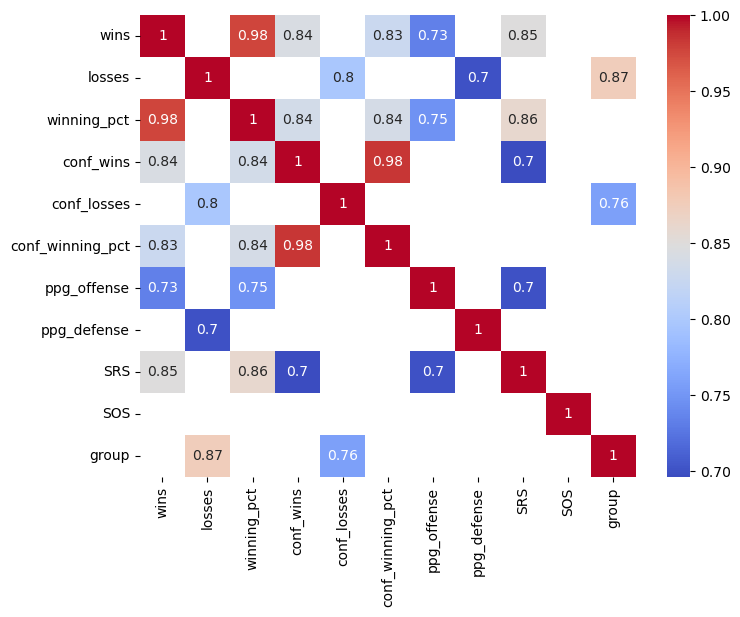

In [12]:
# Create a correlation heatmap
corr_matrix = df_predictions.corr()

# Create a mask to filter values greater than 0.69
mask = corr_matrix > 0.69

# Create a filtered correlation matrix
filtered_corr_matrix = corr_matrix[mask]

# Create a heatmap of the filtered correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Dependent Variable `winning_pct`

In [13]:
# Generate the Variables
x = 'winning_pct'
y = 'ppg_offense'
team = 'Nebraska'
title = f'Clustering Analysis for {team} comparing {y} vs {x}'


# Generate the main scatter plot
scatter_plot = df_predictions.reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team"
).opts(title=title, yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions.index.str.contains(team)

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions.loc[filter_condition].reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Overlay the two plots to show the original scatter plot and the filtered points
plot_ppg_offense_winning_pct = scatter_plot * filtered_points

# Render the final plot
plot_ppg_offense_winning_pct

:Overlay
   .NdOverlay.I  :NdOverlay   [group]
      :Scatter   [winning_pct]   (ppg_offense,team)
   .NdOverlay.II :NdOverlay   [group]
      :Scatter   [winning_pct]   (ppg_offense,team)

In [14]:
# Generate the Variables
x = 'winning_pct'
y = 'ppg_defense'
team = 'Nebraska'
title = f'Clustering Analysis for {team} comparing {y} vs {x}'

# Generate the main scatter plot
scatter_plot = df_predictions.reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team"
).opts(title=title, yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions.index.str.contains(team)

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions.loc[filter_condition].reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Overlay the two plots to show the original scatter plot and the filtered points with stars
plot_ppg_defense_winning_pct = scatter_plot * filtered_points

# Render the final plot
plot_ppg_defense_winning_pct

:Overlay
   .NdOverlay.I  :NdOverlay   [group]
      :Scatter   [winning_pct]   (ppg_defense,team)
   .NdOverlay.II :NdOverlay   [group]
      :Scatter   [winning_pct]   (ppg_defense,team)

In [15]:
# Generate the Variables
x = 'winning_pct'
y = 'SRS'
team = 'Nebraska'
title = f'Clustering Analysis for {team} comparing {y} vs {x}'

# Generate the main scatter plot
scatter_plot = df_predictions.reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team"
).opts(title=title, yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions.index.str.contains(team)

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions.loc[filter_condition].reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Overlay the two plots to show the original scatter plot and the filtered points with stars
plot_srs_winning_pct = scatter_plot * filtered_points

# Render the final plot
plot_srs_winning_pct

:Overlay
   .NdOverlay.I  :NdOverlay   [group]
      :Scatter   [winning_pct]   (SRS,team)
   .NdOverlay.II :NdOverlay   [group]
      :Scatter   [winning_pct]   (SRS,team)

In [16]:
# Generate the Variables
x = 'winning_pct'
y = 'SOS'
team = 'Nebraska'
title = f'Clustering Analysis for {team} comparing {y} vs {x}'

# Generate the main scatter plot
scatter_plot = df_predictions.reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team"
).opts(title=title, yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions.index.str.contains(team)

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions.loc[filter_condition].reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Overlay the two plots to show the original scatter plot and the filtered points with stars
plot_sos_winning_pct = scatter_plot * filtered_points

# Render the final plot
plot_sos_winning_pct

:Overlay
   .NdOverlay.I  :NdOverlay   [group]
      :Scatter   [winning_pct]   (SOS,team)
   .NdOverlay.II :NdOverlay   [group]
      :Scatter   [winning_pct]   (SOS,team)

### Dependent Variable `ppg_offense`

In [17]:
# Generate the Variables
x = 'ppg_offense'
y = 'ppg_defense'
team = 'Nebraska'
title = f'Clustering Analysis for {team} comparing {y} vs {x}'


# Generate the main scatter plot
scatter_plot = df_predictions.reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team"
).opts(title=title, yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions.index.str.contains(team)

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions.loc[filter_condition].reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Overlay the two plots to show the original scatter plot and the filtered points
plot_ppg_defenese_ppg_offense = scatter_plot * filtered_points

# Render the final plot
plot_ppg_defenese_ppg_offense

:Overlay
   .NdOverlay.I  :NdOverlay   [group]
      :Scatter   [ppg_offense]   (ppg_defense,team)
   .NdOverlay.II :NdOverlay   [group]
      :Scatter   [ppg_offense]   (ppg_defense,team)

In [18]:
# Generate the Variables
x = 'ppg_offense'
y = 'SRS'
team = 'Nebraska'
title = f'Clustering Analysis for {team} comparing {y} vs {x}'


# Generate the main scatter plot
scatter_plot = df_predictions.reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team"
).opts(title=title, yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions.index.str.contains(team)

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions.loc[filter_condition].reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Overlay the two plots to show the original scatter plot and the filtered points
plot_srs_ppg_offense = scatter_plot * filtered_points

# Render the final plot
plot_srs_ppg_offense

:Overlay
   .NdOverlay.I  :NdOverlay   [group]
      :Scatter   [ppg_offense]   (SRS,team)
   .NdOverlay.II :NdOverlay   [group]
      :Scatter   [ppg_offense]   (SRS,team)

In [19]:
# Generate the Variables
x = 'ppg_offense'
y = 'SOS'
team = 'Nebraska'
title = f'Clustering Analysis for {team} comparing {y} vs {x}'


# Generate the main scatter plot
scatter_plot = df_predictions.reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team"
).opts(title=title, yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions.index.str.contains(team)

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions.loc[filter_condition].reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Overlay the two plots to show the original scatter plot and the filtered points
plot_sos_ppg_offense = scatter_plot * filtered_points

# Render the final plot
plot_sos_ppg_offense

:Overlay
   .NdOverlay.I  :NdOverlay   [group]
      :Scatter   [ppg_offense]   (SOS,team)
   .NdOverlay.II :NdOverlay   [group]
      :Scatter   [ppg_offense]   (SOS,team)

### Dependent Variable `ppg_defense`

In [20]:
# Generate the Variables
x = 'ppg_defense'
y = 'SRS'
team = 'Nebraska'
title = f'Clustering Analysis for {team} comparing {y} vs {x}'


# Generate the main scatter plot
scatter_plot = df_predictions.reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team"
).opts(title=title, yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions.index.str.contains(team)

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions.loc[filter_condition].reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Overlay the two plots to show the original scatter plot and the filtered points
plot_srs_ppg_defense = scatter_plot * filtered_points

# Render the final plot
plot_srs_ppg_defense

:Overlay
   .NdOverlay.I  :NdOverlay   [group]
      :Scatter   [ppg_defense]   (SRS,team)
   .NdOverlay.II :NdOverlay   [group]
      :Scatter   [ppg_defense]   (SRS,team)

In [21]:
# Generate the Variables
x = 'ppg_defense'
y = 'SOS'
team = 'Nebraska'
title = f'Clustering Analysis for {team} comparing {y} vs {x}'


# Generate the main scatter plot
scatter_plot = df_predictions.reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team"
).opts(title=title, yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions.index.str.contains(team)

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions.loc[filter_condition].reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Overlay the two plots to show the original scatter plot and the filtered points
plot_sos_ppg_defense = scatter_plot * filtered_points

# Render the final plot
plot_sos_ppg_defense

:Overlay
   .NdOverlay.I  :NdOverlay   [group]
      :Scatter   [ppg_defense]   (SOS,team)
   .NdOverlay.II :NdOverlay   [group]
      :Scatter   [ppg_defense]   (SOS,team)

### Dependent Variable `SOS`

In [22]:
# Generate the Variables
x = 'SOS'
y = 'SRS'
team = 'Nebraska'
title = f'Clustering Analysis for {team} comparing {y} vs {x}'

# Generate the main scatter plot
scatter_plot = df_predictions.reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team"
).opts(title=title, yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions.index.str.contains(team)

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions.loc[filter_condition].reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Overlay the two plots to show the original scatter plot and the filtered points with stars
plot_srs_sos = scatter_plot * filtered_points

# Render the final plot
plot_srs_sos

:Overlay
   .NdOverlay.I  :NdOverlay   [group]
      :Scatter   [SOS]   (SRS,team)
   .NdOverlay.II :NdOverlay   [group]
      :Scatter   [SOS]   (SRS,team)

### PCA Analysis

In [23]:
# Create a PCA model instance and set `n_components=3`.
pca = PCA(n_components=3)

# Fit the  data to the PCA
data_pca = pca.fit_transform(df_scaled)

# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_

array([0.70345994, 0.12972963, 0.07077272])

In [24]:
# Creating a DataFrame with the PCA data
df_pca = pd.DataFrame(data_pca, columns=["PC1", "PC2", "PC3"])

# Set the index to the team column
df_pca['team'] = df_data.index
df_pca = df_pca.set_index('team')

# Review the DataFrame
df_pca.head()

,PC1,PC2,PC3
team,,,
(Florida State)-2000,5.405136,-0.949077,-0.468887
(Clemson)-2000,2.915971,-0.254791,0.100670
(Georgia Tech)-2000,2.846367,-0.135301,-0.291479
(Virginia)-2000,0.200641,-0.397361,-0.838220
(North Carolina State)-2000,0.921207,0.018845,0.474476


In [25]:
# Create a a list to store inertia values
inertia = []

# Create a a list to store the values of k
k = list(range(1, 11))

# Create a for loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the home_sales_df DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the K-means model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(df_pca)
    inertia.append(k_model.inertia_)

# Create a dictionary that holds the list values for k and inertia
elbow_data = {"k": k, "inertia": inertia}

# Create a DataFrame using the elbow_data dictionary
df_elbow_pca = pd.DataFrame(elbow_data)

# Plot the DataFrame
df_elbow_pca.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

C:\Users\grant\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\grant\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\grant\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\grant\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\grant\anaco

:Curve   [k]   (inertia)

In [26]:
# Initialize the K-Means model with n_clusters=3
model = KMeans(n_clusters=3, random_state=1)

# Fit the K-Means model using the PCA data
model.fit(df_pca)

# Predict the model segments (clusters)
data_cluster = model.predict(df_pca)

# Create a copy of the DataFrame with the PCA data
df_predictions_pca = df_pca.copy()

# Add a new column to the DataFrame with the predicted clusters
df_predictions_pca['data_cluster'] = data_cluster

# Display sample data
df_predictions_pca.head()

C:\Users\grant\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,PC1,PC2,PC3,data_cluster
team,,,,
(Florida State)-2000,5.405136,-0.949077,-0.468887,1
(Clemson)-2000,2.915971,-0.254791,0.100670,1
(Georgia Tech)-2000,2.846367,-0.135301,-0.291479,1
(Virginia)-2000,0.200641,-0.397361,-0.838220,0
(North Carolina State)-2000,0.921207,0.018845,0.474476,0


In [27]:
# Generate the PCA plots
scatter_plot = df_predictions_pca.hvplot.scatter(
    x="PC1",
    y="PC2",
    by="data_cluster",
    hover_cols="team"
).opts(title='PC2 vs PC1 for Nebraska', yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions_pca.index.str.contains('Nebraska')

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions_pca.loc[filter_condition].reset_index().hvplot.scatter(
    x="PC1",
    y="PC2",
    by="data_cluster",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Create composite plot
plot_pc2_pc1 = scatter_plot * filtered_points

# Render the final plot
plot_pc2_pc1

:Overlay
   .NdOverlay.I  :NdOverlay   [data_cluster]
      :Scatter   [PC1]   (PC2,team)
   .NdOverlay.II :NdOverlay   [data_cluster]
      :Scatter   [PC1]   (PC2,team)

In [28]:
# Generate the PCA plots
scatter_plot = df_predictions_pca.hvplot.scatter(
    x="PC1",
    y="PC3",
    by="data_cluster",
    hover_cols="team"
).opts(title='PC3 vs PC1 for Nebraska', yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions_pca.index.str.contains('Nebraska')

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions_pca.loc[filter_condition].reset_index().hvplot.scatter(
    x="PC1",
    y="PC2",
    by="data_cluster",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Create composite plot
plot_pc3_pc1 = scatter_plot * filtered_points

# Render the final plot
plot_pc3_pc1

:Overlay
   .NdOverlay.I  :NdOverlay   [data_cluster]
      :Scatter   [PC1]   (PC3,team)
   .NdOverlay.II :NdOverlay   [data_cluster]
      :Scatter   [PC1]   (PC2,team)

In [29]:
# Generate the PCA plots
scatter_plot = df_predictions_pca.hvplot.scatter(
    x="PC2",
    y="PC3",
    by="data_cluster",
    hover_cols="team"
).opts(title='PC3 vs PC2 for Nebraska', yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions_pca.index.str.contains('Nebraska')

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions_pca.loc[filter_condition].reset_index().hvplot.scatter(
    x="PC1",
    y="PC2",
    by="data_cluster",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Create composite plot
plot_pc3_pc2 = scatter_plot * filtered_points

# Render the final plot
plot_pc3_pc2

:Overlay
   .NdOverlay.I  :NdOverlay   [data_cluster]
      :Scatter   [PC2]   (PC3,team)
   .NdOverlay.II :NdOverlay   [data_cluster]
      :Scatter   [PC1]   (PC2,team)

In [30]:
plot_final = plot_pc2_pc1 + plot_pc3_pc1 + plot_pc3_pc2

plot_final

:Layout
   .Overlay.I   :Overlay
      .NdOverlay.I  :NdOverlay   [data_cluster]
         :Scatter   [PC1]   (PC2,team)
      .NdOverlay.II :NdOverlay   [data_cluster]
         :Scatter   [PC1]   (PC2,team)
   .Overlay.II  :Overlay
      .NdOverlay.I  :NdOverlay   [data_cluster]
         :Scatter   [PC1]   (PC3,team)
      .NdOverlay.II :NdOverlay   [data_cluster]
         :Scatter   [PC1]   (PC2,team)
   .Overlay.III :Overlay
      .NdOverlay.I  :NdOverlay   [data_cluster]
         :Scatter   [PC2]   (PC3,team)
      .NdOverlay.II :NdOverlay   [data_cluster]
         :Scatter   [PC1]   (PC2,team)

### Ad-Hoc Report Generator

In [31]:
### User Inputs

# Available input variables:
# wins, losses, winning_pct, conf_wins, conf_losses, conf_winning_pct, ppg_offense, ppg_defense, SRS, 'SOS'

x = 'SOS'
y = 'SRS'
team = 'Kansas State'

# Generate the main scatter plot
title = f'Clustering Analysis for {team} comparing {y} vs {x}'
scatter_plot = df_predictions.reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team"
).opts(title=title, yformatter="%.0f", width=750, height=500)

# Generate the filtered plot
filter_condition = df_predictions.index.str.startswith(f'({team})-')

# Generate a scatter plot with stars for selected team
filtered_points = df_predictions.loc[filter_condition].reset_index().hvplot.scatter(
    x=x,
    y=y,
    by="group",
    hover_cols="team",
    marker='s',
    color='black',
    size=50
).opts(show_legend=False, width=750, height=500)

# Overlay the two plots to show the original scatter plot and the filtered points with stars
final_plot = scatter_plot * filtered_points

# Render the final plot
final_plot

:Overlay
   .NdOverlay.I  :NdOverlay   [group]
      :Scatter   [SOS]   (SRS,team)
   .NdOverlay.II :NdOverlay   [group]
      :Scatter   [SOS]   (SRS,team)

In [32]:
df_predictions.columns

Index(['wins', 'losses', 'winning_pct', 'conf_wins', 'conf_losses',
       'conf_winning_pct', 'ppg_offense', 'ppg_defense', 'SRS', 'SOS',
       'group'],
      dtype='object')